# 安徽安庆市项目`WRF-CMAQ`模拟分析
## 模拟结果分析：*`Integrated Source Apportionment Method`*

---
*@author: Evan*\
*@date: 2023-08-08*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../../src/')
import ModelEvaLib as me
from namelist import *

## 读取数据

In [2]:
isam = xr.open_dataset(isamfile2)
isam

<xarray.Dataset>
Dimensions:    (time: 744, level: 26, y: 138, x: 135)
Coordinates:
  * time       (time) datetime64[ns] 2023-07-01 ... 2023-07-31T23:00:00
  * level      (level) float64 1e+03 998.0 995.8 993.4 ... 703.9 659.0 616.2
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    PM_AnQ     (time, level, y, x) float32 ...
    PM_AQI     (time, level, y, x) float32 ...
    PM_AQT     (time, level, y, x) float32 ...
    PM_AQA     (time, level, y, x) float32 ...
    PM_AQP     (time, level, y, x) float32 ...
    PM_OTH     (time, level, y, x) float32 ...
    PM_ICO     (time, level, y, x) float32 ...
    PM_BCO     (time, level, y, x) float32 ...
Attributes:
    case:        Anqing_202307
    grid:        CN3AH_135X138
    createtime:  2023-08-08

In [4]:
# get the variables with filter
name_list = [name for name in list(isam.variables) if 'PM' in name]
tag_list  = [name.split('_')[1] for name in name_list]

print(name_list)
print(tag_list)

data_list = []
for i in range(len(name_list)): 
    data_list.append(isam[name_list[i]])

['PM_AnQ', 'PM_AQI', 'PM_AQT', 'PM_AQA', 'PM_AQP', 'PM_OTH', 'PM_ICO', 'PM_BCO']
['AnQ', 'AQI', 'AQT', 'AQA', 'AQP', 'OTH', 'ICO', 'BCO']


In [5]:
L1_dict = {}
L2_dict = {}

for tag, var in zip(tag_list, data_list):
    # 在 L1 字典中存储 L1 变量
    L1_dict[f"{tag}"] = var[:,0,:,:]
    # L1_dict[f"{tag}_L1"] = np.mean(var[:,:4,:,:], axis=1)
    
    # 在 L2 字典中存储 L2 变量
    L2_dict[f"{tag}"] = np.mean(var[:,4:19,:,:], axis=1)

In [6]:
import geopandas as gpd
import shapely.geometry as sgeom
from shapely.prepared import prep

def polygon_to_mask(polygon, x, y):
    '''
    Generate a mask array of points falling into the polygon
    '''
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    mask = np.zeros(x.shape, dtype=bool)

    # if each point falls into a polygon, without boundaries
    prepared = prep(polygon)
    for index in np.ndindex(x.shape):
        point = sgeom.Point(x[index], y[index])
        if prepared.contains(point):
            mask[index] = True

    return mask

def mask_to_mean(var,mask_da):
    '''
    Calculate the mean of a variable after applying a mask.

    Parameters:
        var (xarray.DataArray): Input variable.
        mask_da (xarray.DataArray): Mask with dimensions ('y', 'x').

    Returns:
        xarray.DataArray: Mean of the masked variable along dimensions ('y', 'x').

    '''
    
    masked = var.where(mask_da)
    mean = masked.mean(dim=['y','x'],skipna=True)
    
    return mean

In [8]:
lon = isam.longitude
lat = isam.latitude
shp = gpd.read_file(shpurban)

mask = polygon_to_mask(shp.geometry[0],lon,lat)
mask_da = xr.DataArray(mask,dims=('y','x'))

# var_L1_dict = {key + '_mean': value for key, value in L1_dict.items()}

mean_dict = {}
for key, variable in L1_dict.items():
    mean_dict[key] = mask_to_mean(variable, mask_da)

In [9]:
df_L1 = pd.DataFrame.from_dict(mean_dict, orient='columns')
df_L1.index = pd.date_range(timestart,timeend,freq='h')

df_mda8 = df_L1.resample('D').mean()

df_mda8.keys()

Index(['AnQ', 'AQI', 'AQT', 'AQA', 'AQP', 'OTH', 'ICO', 'BCO'], dtype='object')

In [10]:
# Sections
tags_section = ['AQI', 'AQT', 'AQA', 'AQP']
df_section = df_mda8[tags_section]
df_ratio_section = df_section.div(df_section.sum(axis=1),axis=0) * 100

# Regions
tags_region = ['AnQ', 'OTH', 'ICO', 'BCO']
df_region = df_mda8[tags_region]
df_ratio_region = df_region.div(df_region.sum(axis=1),axis=0) * 100

## 画图

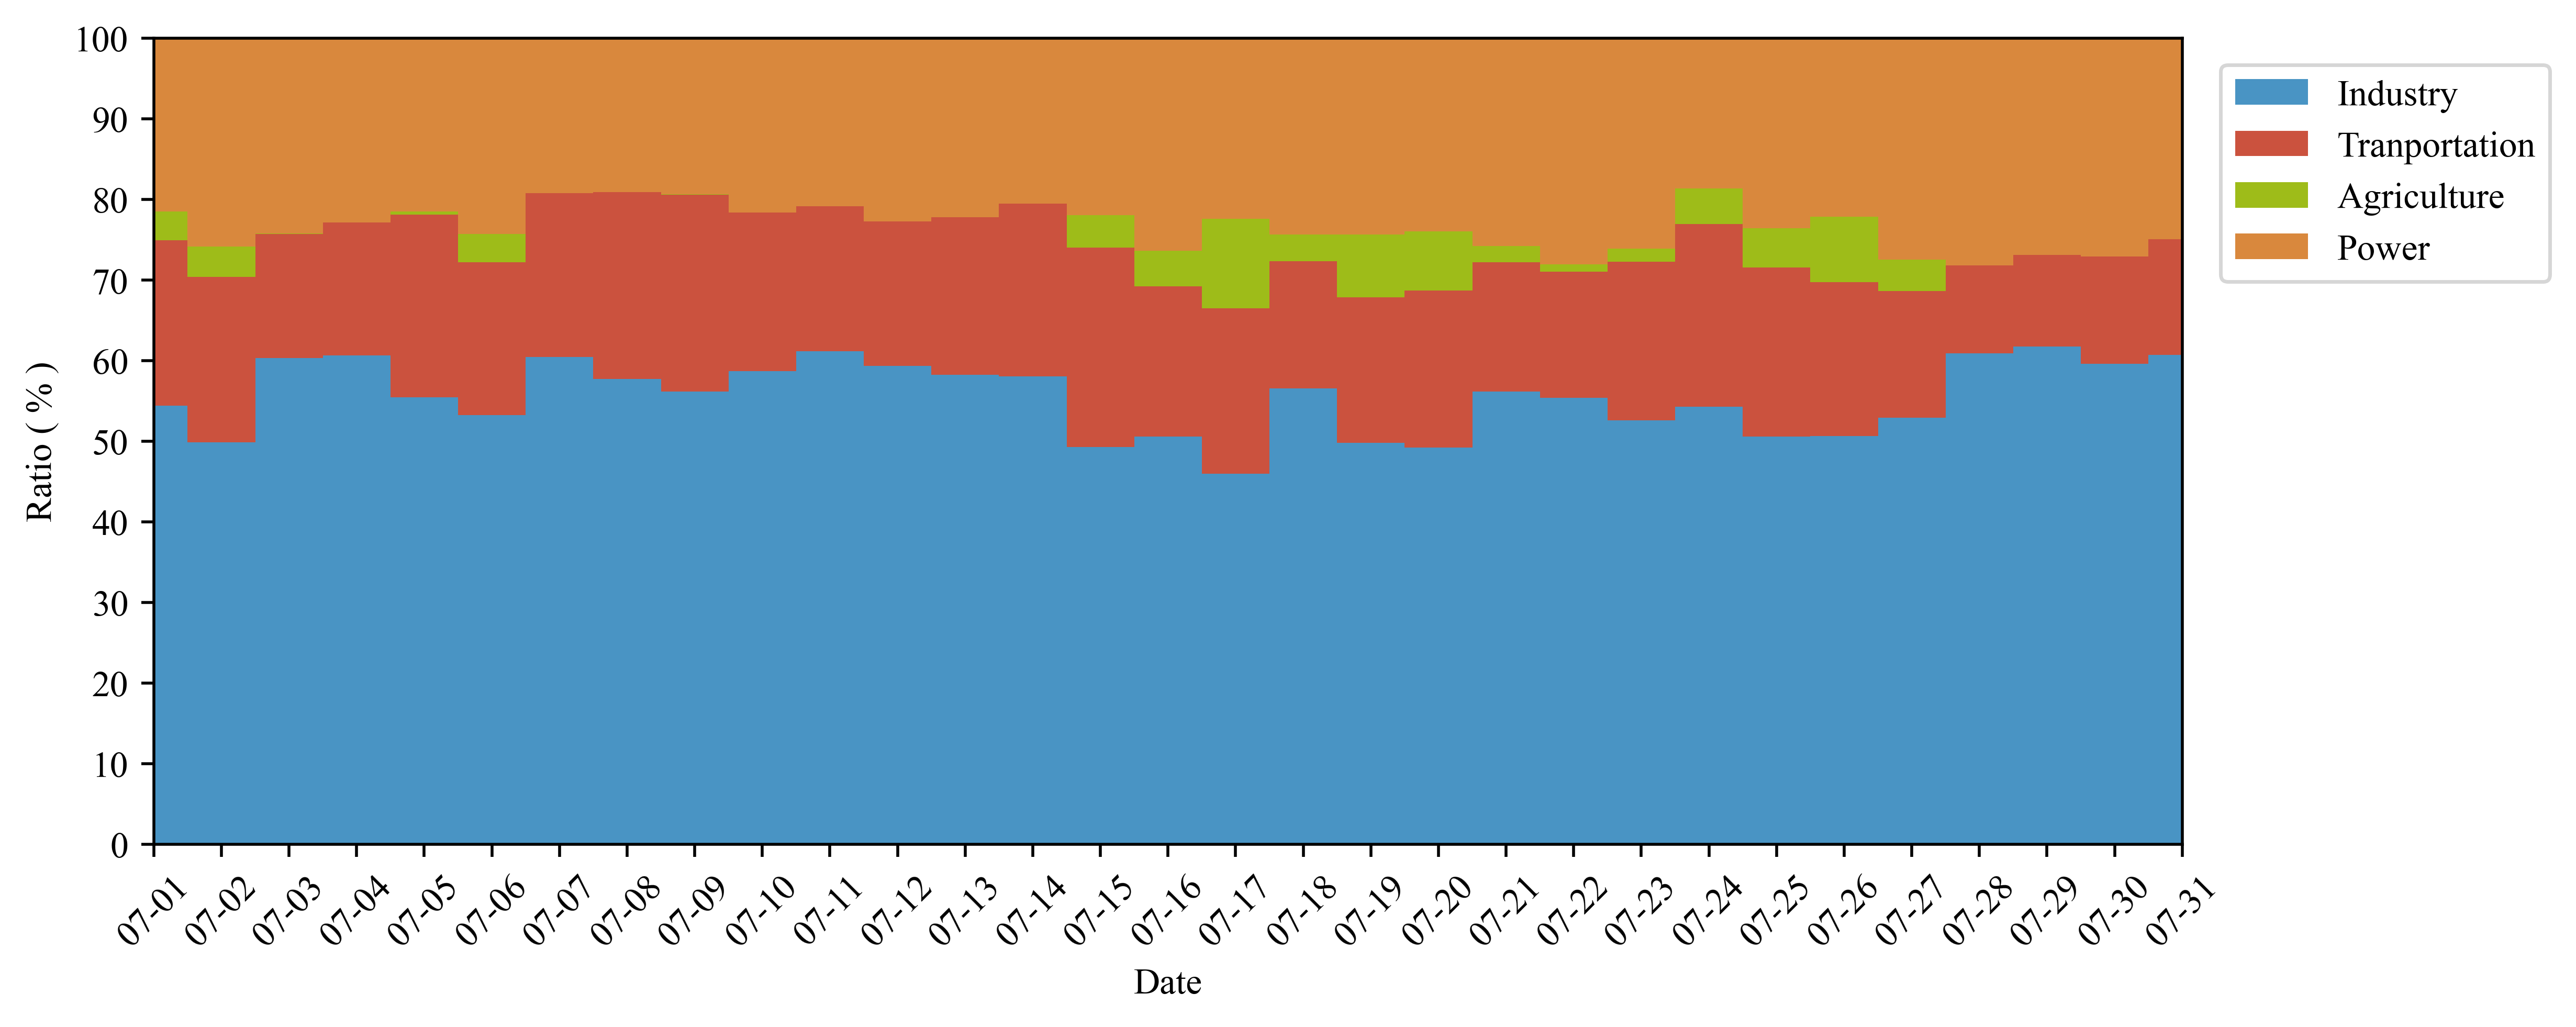

In [11]:
monthdays = 31
ts = np.arange(0, monthdays)

data = {
    'AQI': {'label': 'Industry', 'color': '#4994c4'},
    'AQT': {'label': 'Tranportation', 'color': '#cb523e'},
    'AQA': {'label': 'Agriculture', 'color': '#9ebc19'},
    'AQP': {'label': 'Power', 'color': '#d9883d'},
}

fig, ax = plt.subplots(figsize=(10, 4), dpi=500)

bottom = np.zeros(len(ts))

for key, value in data.items():
    b = ax.bar(ts, df_ratio_section[key], bottom=bottom, color=value['color'], width=1)
    bottom += df_ratio_section[key]
    data[key]['bar'] = b

ax.legend([data[key]['bar'][0] for key in data.keys()],
          [data[key]['label'] for key in data.keys()],
          bbox_to_anchor=(1.01,0.99))
ax.set_xlabel('Date')
ax.set_ylabel('Ratio ( % )')
ax.set_xticks(np.arange(0, monthdays))
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'), rotation=45)
ax.set_yticks(np.arange(0, 101, 10))
ax.set_ylim(0, 100)
ax.set_xlim(0, monthdays-1)

plt.show()

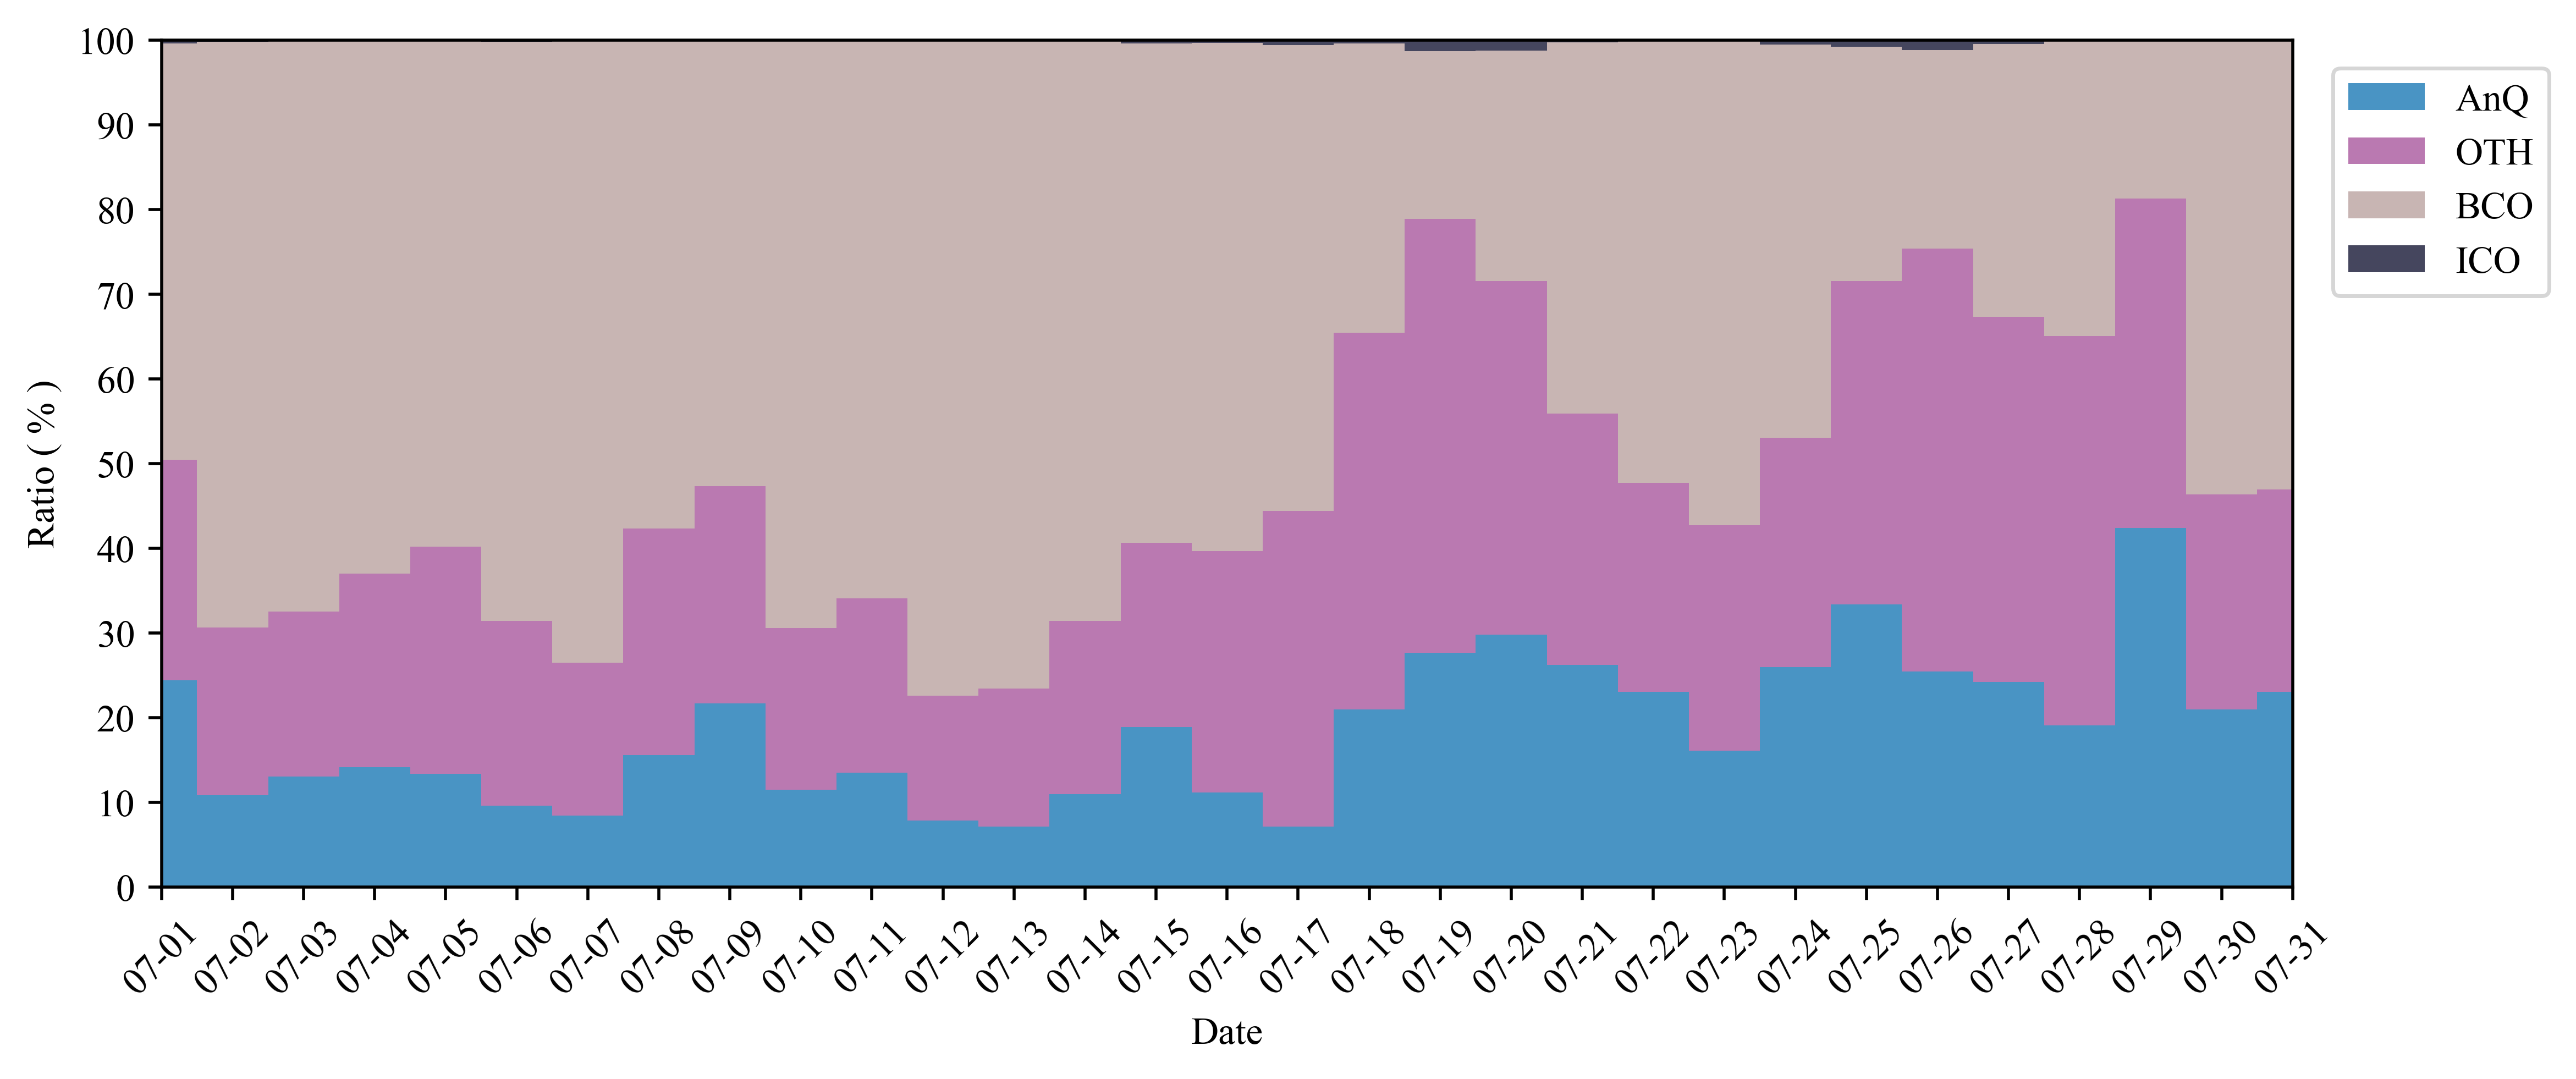

In [12]:
monthdays = 31
ts = np.arange(0, monthdays)

data = {
    'AnQ' : {'label': 'AnQ', 'color': '#4994c4'},
    'OTH': {'label': 'OTH', 'color': '#ba79b1'},
    'BCO': {'label': 'BCO', 'color': '#c8b5b3'},
    'ICO': {'label': 'ICO', 'color': '#45465e'}
}

fig, ax = plt.subplots(figsize=(10, 4), dpi=500)

bottom = np.zeros(len(ts))

for key, value in data.items():
    b = ax.bar(ts, df_ratio_region[key], bottom=bottom, color=value['color'], width=1)
    bottom += df_ratio_region[key]
    data[key]['bar'] = b

ax.legend([data[key]['bar'][0] for key in data.keys()],
          [data[key]['label'] for key in data.keys()],
          bbox_to_anchor=(1.01,0.99))
ax.set_xlabel('Date')
ax.set_ylabel('Ratio ( % )')
ax.set_xticks(np.arange(0, monthdays))
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'), rotation=45)
ax.set_yticks(np.arange(0, 101, 10))
ax.set_ylim(0, 100)
ax.set_xlim(0, monthdays-1)

plt.show()